In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns    # plot tools


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ihsgstockdata/DaftarSaham.csv
/kaggle/input/ihsgstockdata/minutes/MAPB.csv
/kaggle/input/ihsgstockdata/minutes/SIPD.csv
/kaggle/input/ihsgstockdata/minutes/ROTI.csv
/kaggle/input/ihsgstockdata/minutes/MBTO.csv
/kaggle/input/ihsgstockdata/minutes/SURE.csv
/kaggle/input/ihsgstockdata/minutes/IFII.csv
/kaggle/input/ihsgstockdata/minutes/CPIN.csv
/kaggle/input/ihsgstockdata/minutes/NASA.csv
/kaggle/input/ihsgstockdata/minutes/HAIS.csv
/kaggle/input/ihsgstockdata/minutes/MCOR.csv
/kaggle/input/ihsgstockdata/minutes/TFCO.csv
/kaggle/input/ihsgstockdata/minutes/DEWI.csv
/kaggle/input/ihsgstockdata/minutes/MLPL.csv
/kaggle/input/ihsgstockdata/minutes/KOTA.csv
/kaggle/input/ihsgstockdata/minutes/ADRO.csv
/kaggle/input/ihsgstockdata/minutes/ECII.csv
/kaggle/input/ihsgstockdata/minutes/MEDS.csv
/kaggle/input/ihsgstockdata/minutes/BINO.csv
/kaggle/input/ihsgstockdata/minutes/ISSP.csv
/kaggle/input/ihsgstockdata/minutes/TALF.csv
/kaggle/input/ihsgstockdata/minutes/YULE.csv
/kaggle/inp

Import Data

In [2]:
import seaborn as sns 
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM 
from sklearn.metrics import mean_absolute_error

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
df = pd.read_csv('../input/ihsgstockdata/daily/TLKM.csv')
df['timestamp'] = pd.to_datetime(df['timestamp']) 
df = df.set_index('timestamp')
print(f"Jumlah Baris = {df.shape[0]}")
df.head()

Jumlah Baris = 5670


,open,low,high,close,volume
timestamp,,,,,
2001-04-16,835,825,835,825,0
2001-04-17,835,825,835,825,0
2001-04-18,835,825,835,825,0
2001-04-19,835,825,835,825,0
2001-04-20,835,825,835,825,0


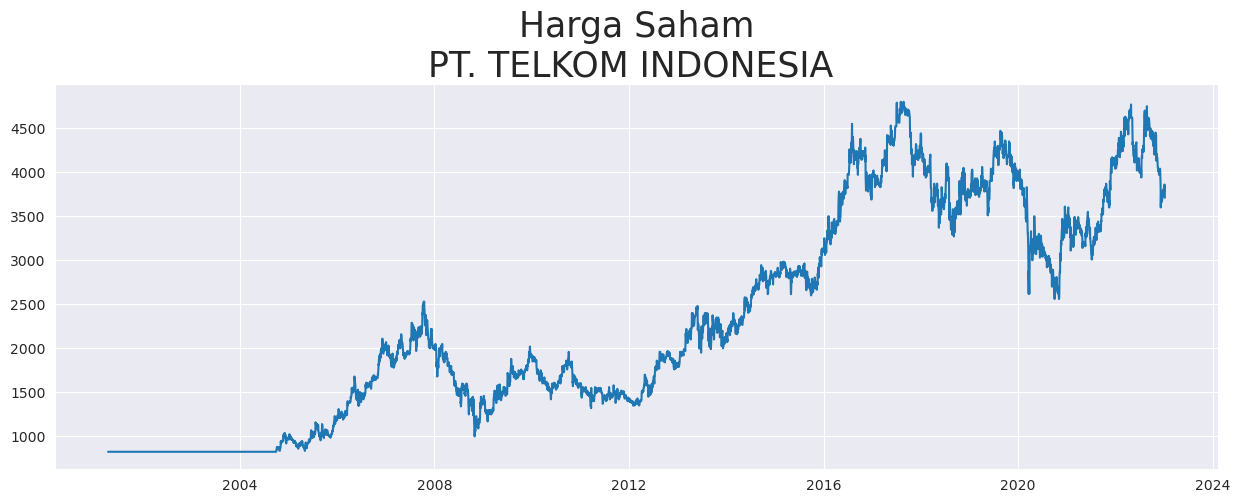

In [4]:
plt.figure(figsize=(15,5))
sns.set_style('darkgrid')
plt.plot(df.index, df['close'])
plt.title("Harga Saham\nPT. TELKOM INDONESIA ", fontsize=25)
plt.show()

In [5]:
ms = MinMaxScaler()
df['close'] = ms.fit_transform(df[['close']])

In [6]:
def split_data(df, train_size): 
  size = int(len(df) * train_size)
  train, test = df.iloc[0:size], df.iloc[size:len(df)]
  return train, test

In [7]:
train, test = split_data(df['close'], 0.8) #80% Train

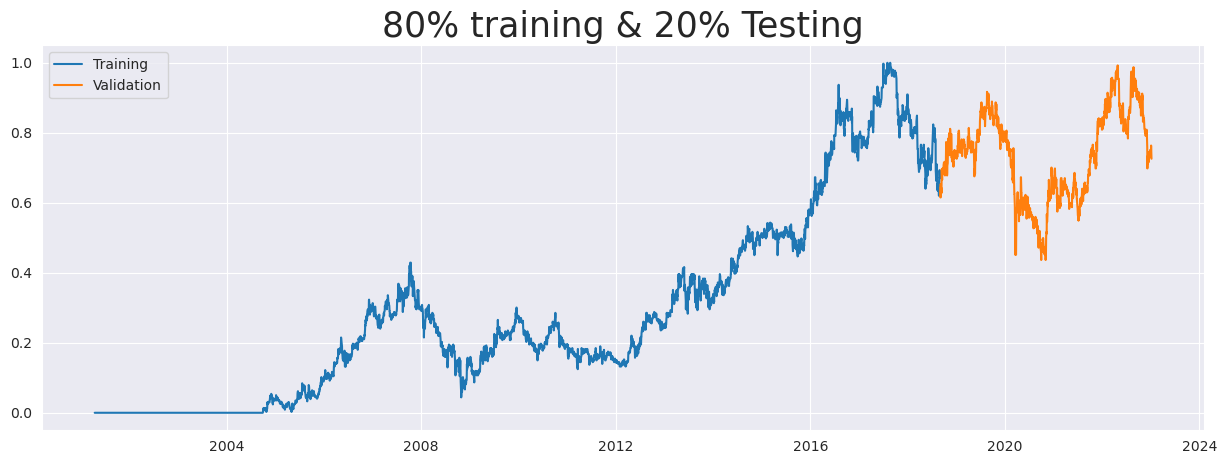

In [8]:
train, test = split_data(df['close'], 0.8) #80% Train
plt.figure(figsize=(15,5))
plt.plot(train)
plt.plot(test)
plt.legend(labels=['Training', 'Validation'])
plt.title('80% training & 20% Testing', fontsize=25)
plt.show()

In [9]:
def split_target(df, look_back=1):
    X, y = [], []
    for i in range(len(df) - look_back):
        a = df[i:(i + look_back), 0]
        X.append(a)
        y.append(df[i + look_back, 0])
    return np.array(X), np.array(y)

In [10]:
X_train, y_train = split_target(train.values.reshape(len(train), 1))
X_test, y_test = split_target(test.values.reshape(len(test), 1))

In [11]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

BUILD MODEL

In [12]:
model = Sequential([LSTM(100, input_shape=(1, 1), return_sequences=True),
                    LSTM(50), 
                    Dense(25, activation='relu'),
                    Dense(1)])

In [13]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_mae') is not None and logs.get('val_mae') < 0.015:
      self.model.stop_training = True

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, 
              metrics=["mae"], 
              loss=tf.keras.losses.Huber())

In [15]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=2000, 
                    batch_size=128, 
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                    callbacks=[Callback()])

Epoch 1/2000
36/36 [==============================] - 7s 42ms/step - loss: 0.0720 - mae: 0.2764 - val_loss: 0.2600 - val_mae: 0.7103
Epoch 2/2000
36/36 [==============================] - 0s 11ms/step - loss: 0.0664 - mae: 0.2638 - val_loss: 0.2449 - val_mae: 0.6889
Epoch 3/2000
36/36 [==============================] - 0s 11ms/step - loss: 0.0614 - mae: 0.2526 - val_loss: 0.2301 - val_mae: 0.6672
Epoch 4/2000
36/36 [==============================] - 0s 10ms/step - loss: 0.0565 - mae: 0.2420 - val_loss: 0.2149 - val_mae: 0.6443
Epoch 5/2000
36/36 [==============================] - 0s 12ms/step - loss: 0.0517 - mae: 0.2310 - val_loss: 0.1989 - val_mae: 0.6193
Epoch 6/2000
36/36 [==============================] - 0s 11ms/step - loss: 0.0469 - mae: 0.2199 - val_loss: 0.1824 - val_mae: 0.5924
Epoch 7/2000
36/36 [==============================] - 0s 11ms/step - loss: 0.0423 - mae: 0.2081 - val_loss: 0.1654 - val_mae: 0.5632
Epoch 8/2000
36/36 [==============================] - 0s 11ms/step - 

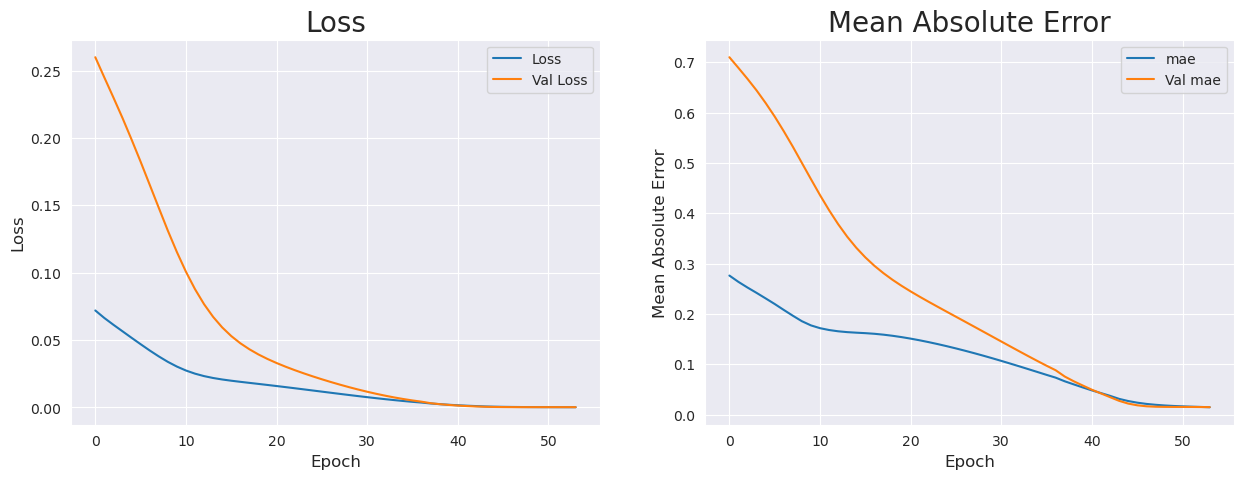

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Loss','Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# MAE
ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])
ax2.legend(['mae','Val mae'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)
plt.show()

36/36 [==============================] - 2s 3ms/step


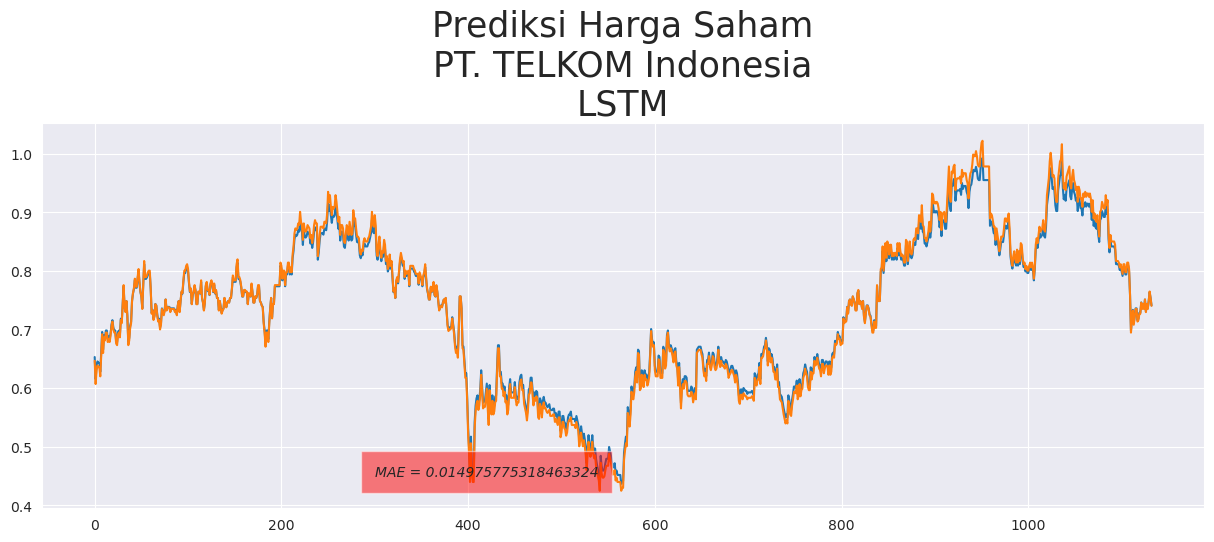

In [17]:
plt.figure(figsize=(15,5))
y_pred = model.predict(X_test)
y_pred = list(np.reshape(y_pred, (1,len(y_pred)))[0])

X_test = np.reshape(X_test, (len(X_test),1))
X_test = list(np.reshape(X_test, (1,len(X_test)))[0])

plt.plot(X_test)
plt.plot(y_pred)
plt.text(300, 0.45, f"MAE = {mean_absolute_error(y_test, y_pred)}", style='italic', bbox={
        'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.title('Prediksi Harga Saham\nPT. TELKOM Indonesia\nLSTM', fontsize=25)
plt.show()

Regresi Linear

In [18]:
# Directory of the dataset 
filename = '../input/ihsgstockdata/daily/TLKM.csv'

# Read the file
Prgoo = pd.read_csv('../input/ihsgstockdata/daily/TLKM.csv')


# Prices is the predict value and initial the independet variable (y)
prices = Prgoo['close'].tolist()
initial = (Prgoo['open']).tolist()
 
#Convert to 1d Vector
prices = np.reshape(prices, (len(prices), 1))
initial = np.reshape(initial, (len(initial), 1))

Prgoo.head(5)

,timestamp,open,low,high,close,volume
0,2001-04-16,835,825,835,825,0
1,2001-04-17,835,825,835,825,0
2,2001-04-18,835,825,835,825,0
3,2001-04-19,835,825,835,825,0
4,2001-04-20,835,825,835,825,0


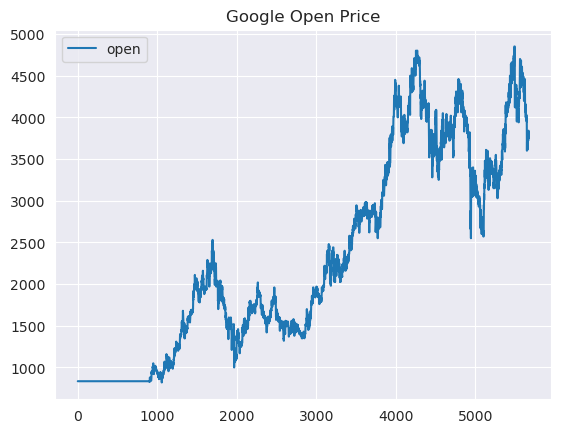

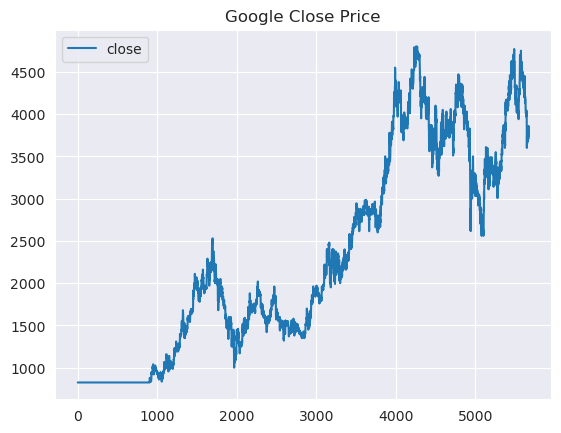

In [19]:
Prgoo[['open']].plot()
plt.title('Google Open Price')
plt.show()

Prgoo[['close']].plot()
plt.title('Google Close Price')
plt.show()

/tmp/ipykernel_21/4163910307.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(Prgoo.corr(),annot=True, linewidth=.5,)


<Axes: >

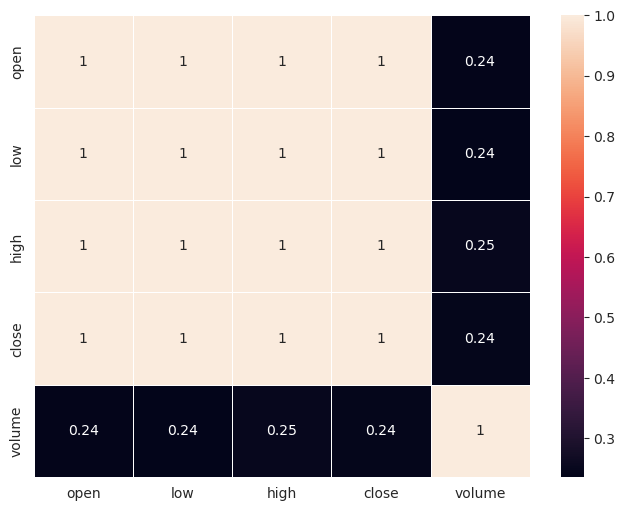

In [20]:
plt.subplots(figsize=(8,6))
sns.heatmap(Prgoo.corr(),annot=True, linewidth=.5,)

/tmp/ipykernel_21/1306958955.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Prgoo['open'], hist = False, kde = True, kde_kws = {'linewidth': 5},label='Open',)
/tmp/ipykernel_21/1306958955.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Prgoo['close'], hist = False, kde

Text(0, 0.5, 'Density')

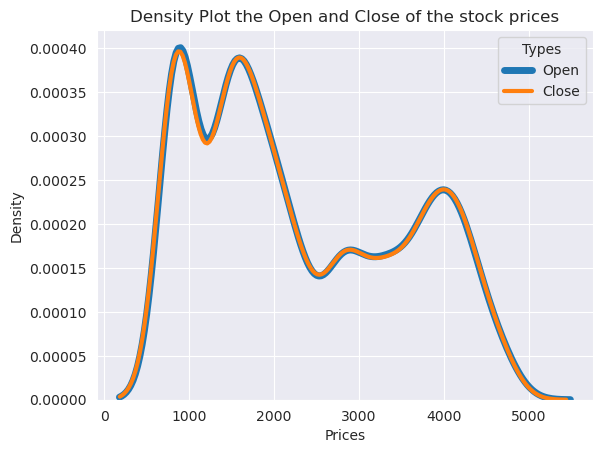

In [21]:
sns.distplot(Prgoo['open'], hist = False, kde = True, kde_kws = {'linewidth': 5},label='Open',) 
sns.distplot(Prgoo['close'], hist = False, kde = True, kde_kws = {'linewidth': 3},label='Close') 

plt.legend(prop={'size': 10}, title = 'Types',loc= 'best')
plt.title('Density Plot the Open and Close of the stock prices')
plt.xlabel('Prices')
plt.ylabel('Density')

Train-set / R2 score: 0.998928463599447


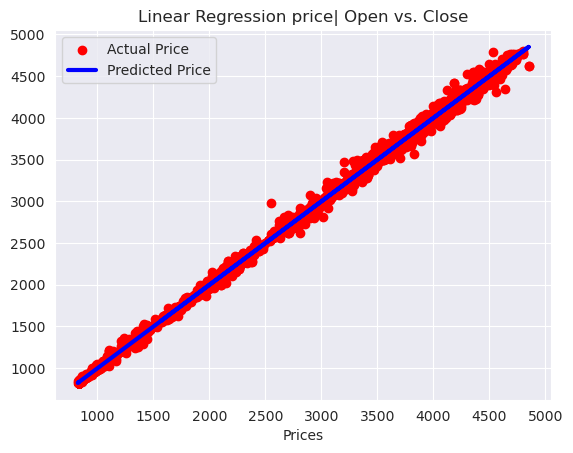

Test-set/ R2 score: 0.9989585109156794


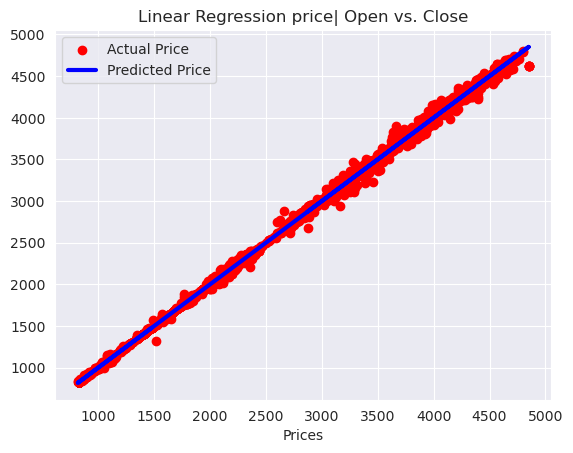

In [22]:
#Splitting the dataset into the Training set and Test set
xtrain, xtest, ytrain, ytest = train_test_split(initial, prices, test_size=0.33, random_state=42)
regressor = LinearRegression()
regressor.fit(xtrain, ytrain)
 
#Train Set Graph
print('Train-set /','R2 score:',r2_score(ytrain,regressor.predict(xtrain)))
plt.scatter(xtrain, ytrain, color='red', label= 'Actual Price') #plotting the initial datapoints
plt.plot(xtrain, regressor.predict(xtrain), color='blue', linewidth=3, label = 'Predicted Price') #plotting the line made by linear regression
plt.title('Linear Regression price| Open vs. Close')
plt.legend()
plt.xlabel('Prices')
plt.show()
 
#Test Set Graph
print('Test-set/','R2 score:',r2_score(ytest,regressor.predict(xtest)))
plt.scatter(xtest, ytest, color='red', label= 'Actual Price') #plotting the initial datapoints
plt.plot(xtest, regressor.predict(xtest), color='blue', linewidth=3, label = 'Predicted Price') #plotting the line made by linear regression
plt.title('Linear Regression price| Open vs. Close')
plt.legend()
plt.xlabel('Prices')
plt.show()

Perusahaan Telkom cukup stabil dalam harga saham  sehingga korelasi sederhana akan mendapatkan kinerja yang baik. 